<a href="https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/tutorials/3_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [ ]:
# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Training

This notebook demonstrates the libraries in [https://github.com/magenta/ddsp/tree/master/ddsp/training](https://github.com/magenta/ddsp/tree/master/ddsp/training). It is a simple example, overfitting a single audio sample, for educational purposes. 

_For a full training pipeline please use [ddsp/training/ddsp_run.py](https://github.com/magenta/ddsp/blob/main/ddsp/training/README.md#train-1) as in the [train_autoencoder.ipynb](https://github.com/magenta/ddsp/blob/main/ddsp/colab/demos/train_autoencoder.ipynb)_.



In [4]:
pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip uninstall -v -y ddsp

In [18]:
# Install and import dependencies
#%tensorflow_version 2.x
#!pip install -qU ddsp
!pip install git+https://github.com/datapplab/sparsenet

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import time

import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
#if True:
    sys.path.append(module_path)
    print(f"appending {module_path} to sys.path")
else:
    print(f"do not appending {module_path} to sys.path")
import ddsp
    

from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers)
    
from notebook_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

do not appending /ssd003/home/burakovr/projects/vova/envs/ddsp/ddsp-playground to sys.path


In [17]:
print(tf. __version__)

2.11.0


In [4]:
import pickle
from ddsp.training import data

data_provider = data.NSynthTfds(split='test')

v = data_provider.get_dataset(True).snapshot(path='content/dataset')
print(v)
#print(data_provider.get_dataset(True))
#with open('data_provider', 'wb') as data_provider_file:
#    pickle.dump(data_provider.get_dataset(True), data_provider_file)

2023-02-14 15:49:10.964144: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2023-02-14 15:49:13.777626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 15:49:13.777725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-14 15:49:13.777788: W tensorflow/compile

<MapDataset element_spec={'audio': TensorSpec(shape=(64000,), dtype=tf.float32, name=None), 'f0_hz': TensorSpec(shape=(1000,), dtype=tf.float32, name=None), 'f0_confidence': TensorSpec(shape=(1000,), dtype=tf.float32, name=None), 'loudness_db': TensorSpec(shape=(1000,), dtype=tf.float32, name=None), 'pitch': TensorSpec(shape=(), dtype=tf.int64, name=None), 'instrument_source': TensorSpec(shape=(), dtype=tf.int64, name=None), 'instrument_family': TensorSpec(shape=(), dtype=tf.int64, name=None), 'instrument': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


# Get a batch of data

In [19]:
# Get a single example from NSynth.
# Takes a few seconds to load from GCS.
data_provider = data.NSynthTfds(split='test')
dataset = data_provider.get_batch(batch_size=1, shuffle=False).take(1).repeat()

2023-02-14 16:48:13.726441: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2023-02-14 16:48:16.549904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 16:48:16.550019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-14 16:48:16.550091: W tensorflow/compile

TypeError: get_batch_from_cached_dataset() missing 1 required positional argument: 'batch_size'

In [20]:
from ddsp.training.models import Autoencoder

a = Autoencoder(testarg=2)

created autoencoder


In [ ]:
batch = next(iter(dataset))
audio = batch['audio']
f0 = batch['f0_hz']
n_samples = audio.shape[1]

#specplot(audio)
#play(audio)
plt.plot(f0)
plt.show()
print(f"f0={f0}")
print(f"instrument={batch['instrument']}")
print(f"instrument_family={batch['instrument_family']}")
print(f"instrument_source={batch['instrument_source']}")
print(f"pitch={batch['pitch']}")
print(f"loudness_db={batch['loudness_db']}")

In [ ]:
play(audio)

# Get a distribution strategy


In [5]:
strategy = train_util.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# Get model and trainer

## python 

In [6]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 512,
                                num_layers = 1,
                                input_keys = ('ld_scaled', 'f0_scaled'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)),
                                sparse_layers=True)

# Create Processors.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
  # Put it together in a model.
  model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)

## or [`gin`](https://github.com/google/gin-config)

In [ ]:
gin_string = """
import ddsp
import ddsp.training

# Preprocessor
models.Autoencoder.preprocessor = @preprocessing.F0LoudnessPreprocessor()
preprocessing.F0LoudnessPreprocessor.time_steps = 1000


# Encoder
models.Autoencoder.encoder = None

# Decoder
models.Autoencoder.decoder = @decoders.RnnFcDecoder()
decoders.RnnFcDecoder.rnn_channels = 256
decoders.RnnFcDecoder.rnn_type = 'gru'
decoders.RnnFcDecoder.ch = 256
decoders.RnnFcDecoder.num_layers = 1
decoders.RnnFcDecoder.input_keys = ('ld_scaled', 'f0_scaled')
decoders.RnnFcDecoder.output_splits = (('amps', 1),
                                       ('harmonic_distribution', 20),
                                       ('noise_magnitudes', 20))

# ProcessorGroup
models.Autoencoder.processor_group = @processors.ProcessorGroup()

processors.ProcessorGroup.dag = [
  (@harmonic/synths.Harmonic(),
    ['amps', 'harmonic_distribution', 'f0_hz']),
  (@noise/synths.FilteredNoise(),
    ['noise_magnitudes']),
  (@add/processors.Add(),
    ['noise/signal', 'harmonic/signal']),
]

# Harmonic Synthesizer
harmonic/synths.Harmonic.name = 'harmonic'
harmonic/synths.Harmonic.n_samples = 64000
harmonic/synths.Harmonic.scale_fn = @core.exp_sigmoid

# Filtered Noise Synthesizer
noise/synths.FilteredNoise.name = 'noise'
noise/synths.FilteredNoise.n_samples = 64000
noise/synths.FilteredNoise.window_size = 0
noise/synths.FilteredNoise.scale_fn = @core.exp_sigmoid
noise/synths.FilteredNoise.initial_bias = -10.0

# Add
add/processors.Add.name = 'add'

models.Autoencoder.losses = [
    @losses.SpectralLoss(),
]
losses.SpectralLoss.loss_type = 'L1'
losses.SpectralLoss.mag_weight = 1.0
losses.SpectralLoss.logmag_weight = 1.0
"""

with gin.unlock_config():
  gin.parse_config(gin_string)

with strategy.scope():
  # Autoencoder arguments are filled by gin.
  model = ddsp.training.models.Autoencoder()
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-4)

# Train

## Build model

In [7]:
# Build model, easiest to just run forward pass.
dataset = trainer.distribute_dataset(dataset)
trainer.build(next(iter(dataset)))
print(tf.keras.Model.summary(model, expand_nested=True))

2023-02-14 14:15:57.488628: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:549] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2023-02-14 14:15:57.624584: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f0_loudness_preprocessor (F  multiple                 0         
 0LoudnessPreprocessor)                                          
                                                                 
 rnn_fc_decoder (RnnFcDecode  multiple                 814171    
 r)                                                              
                                                                 
 processor_group (ProcessorG  multiple                 0         
 roup)                                                           
                                                                 
 spectral_loss (SpectralLoss  multiple                 0         
 )                                                               
                                                                 
Total params: 814,171
Trainable params: 814,171
Non-tra

## Train Loop

In [8]:
dataset_iter = iter(dataset)

for i in range(300):
  losses = trainer.train_step(dataset_iter)
  res_str = 'step: {}\t'.format(i)
  for k, v in losses.items():
    res_str += '{}: {:.2f}\t'.format(k, v)
  print(res_str)

step: 0	spectral_loss: 22.70	total_loss: 22.70	
step: 1	spectral_loss: 21.45	total_loss: 21.45	
step: 2	spectral_loss: 19.63	total_loss: 19.63	
step: 3	spectral_loss: 17.99	total_loss: 17.99	
step: 4	spectral_loss: 17.15	total_loss: 17.15	
step: 5	spectral_loss: 15.99	total_loss: 15.99	
step: 6	spectral_loss: 15.06	total_loss: 15.06	
step: 7	spectral_loss: 14.57	total_loss: 14.57	
step: 8	spectral_loss: 14.12	total_loss: 14.12	
step: 9	spectral_loss: 13.43	total_loss: 13.43	
step: 10	spectral_loss: 13.48	total_loss: 13.48	
step: 11	spectral_loss: 13.35	total_loss: 13.35	
step: 12	spectral_loss: 12.94	total_loss: 12.94	
step: 13	spectral_loss: 12.29	total_loss: 12.29	
step: 14	spectral_loss: 11.90	total_loss: 11.90	
step: 15	spectral_loss: 11.56	total_loss: 11.56	
step: 16	spectral_loss: 11.35	total_loss: 11.35	
step: 17	spectral_loss: 10.99	total_loss: 10.99	
step: 18	spectral_loss: 10.71	total_loss: 10.71	
step: 19	spectral_loss: 10.59	total_loss: 10.59	
step: 20	spectral_loss: 10.35	

# Analyze results

In [9]:
# Run a batch of predictions.
start_time = time.time()
controls =  model(next(dataset_iter))
audio_gen = model.get_audio_from_outputs(controls)
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 43.6 seconds


Original Audio


Resynthesized Audio


Filtered Noise Audio


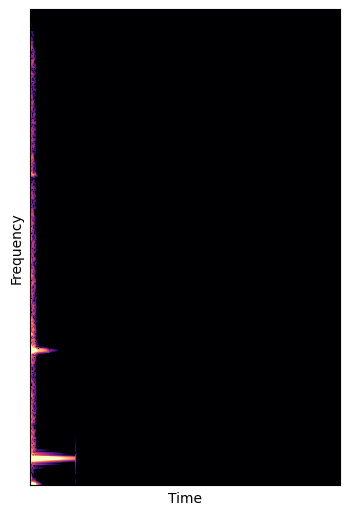

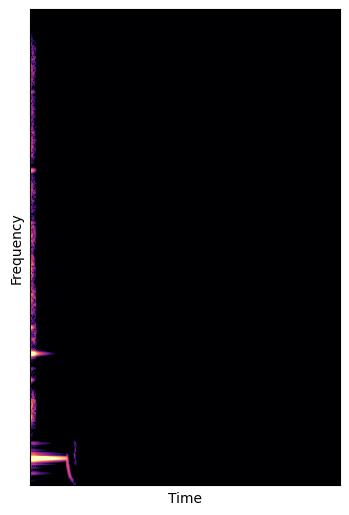

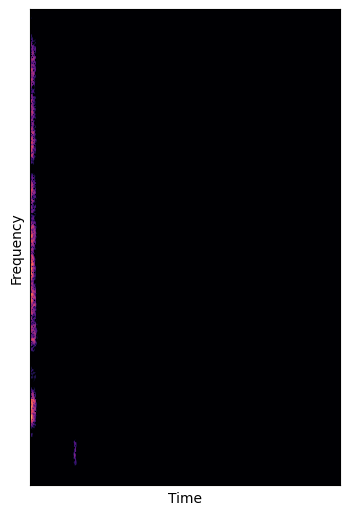

In [10]:
print('Original Audio')
play(audio)
print('Resynthesized Audio')
play(audio_gen)
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
play(audio_noise)

specplot(audio)
specplot(audio_gen)
specplot(audio_noise)

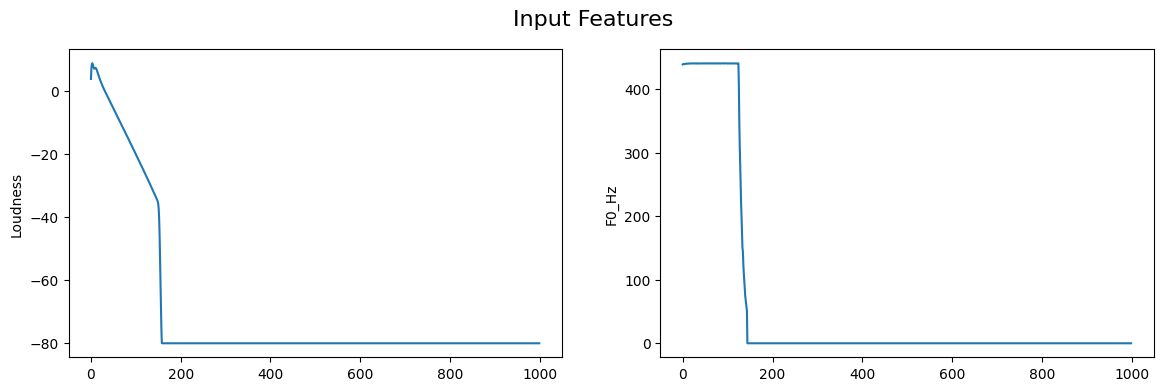

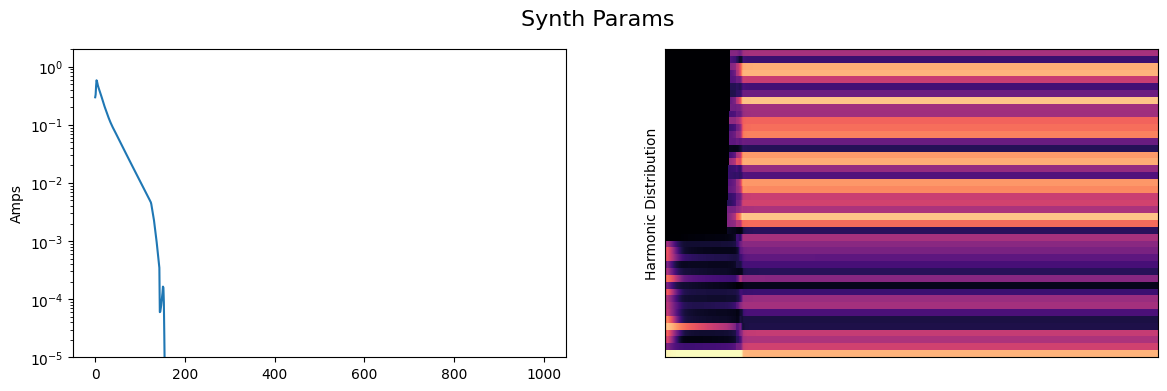

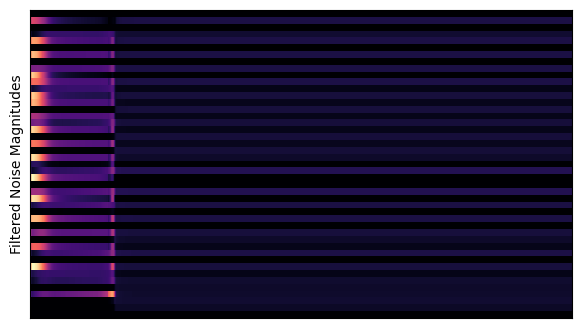

In [11]:
batch_idx = 0
get = lambda key: ddsp.core.nested_lookup(key, controls)[batch_idx]

amps = get('harmonic/controls/amplitudes')
harmonic_distribution = get('harmonic/controls/harmonic_distribution')
noise_magnitudes = get('noise/controls/magnitudes')
f0_hz = get('f0_hz')
loudness = get('loudness_db')

audio_noise = get('noise/signal')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Input Features', fontsize=16)
ax[0].plot(loudness)
ax[0].set_ylabel('Loudness')
ax[1].plot(f0_hz)
ax[1].set_ylabel('F0_Hz')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Synth Params', fontsize=16)
ax[0].semilogy(amps)
ax[0].set_ylabel('Amps')
ax[0].set_ylim(1e-5, 2)
# ax[0].semilogy(harmonic_distribution)
ax[1].matshow(np.rot90(np.log10(harmonic_distribution + 1e-6)),
              cmap=plt.cm.magma, 
              aspect='auto')
ax[1].set_ylabel('Harmonic Distribution')
ax[1].set_xticks([])
_ = ax[1].set_yticks([])

f, ax = plt.subplots(1, 1, figsize=(7, 4))
# f.suptitle('Filtered Noise Params', fontsize=16)
ax.matshow(np.rot90(np.log10(noise_magnitudes + 1e-6)), 
           cmap=plt.cm.magma, 
           aspect='auto')
ax.set_ylabel('Filtered Noise Magnitudes')
ax.set_xticks([])
_ = ax.set_yticks([])
